In [1]:
pip install -q torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
import random
from tqdm.auto import tqdm

In [3]:
import pandas as pd
from numpy import array
from datetime import datetime
import time
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# pd.options.display.float_format = '{:20,.4f}'.format
# float_formatter = "{:.6f}".format
# np.set_printoptions(formatter={'float_kind':float_formatter})

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
data_0 = pd.read_csv('/notebooks/CSVs/indicators_M5_2.csv')

In [ ]:
data = data_0.drop(['time', 'open', 'high', 'low'], axis=1)

In [ ]:
data.columns

In [ ]:
len(data)

In [ ]:
data_train_sc = data[:1300000]
data_val_sc = data[1300000:1600000]
data_test_sc = data[1600000:]

In [ ]:
data_train_sc.to_csv('/notebooks/CSVs/data_train_sc.csv', index=False)
data_val_sc.to_csv('/notebooks/CSVs/data_val_sc.csv', index=False)
data_test_sc.to_csv('/notebooks/CSVs/data_test_sc.csv', index=False)

In [5]:
data_train_sc = pd.read_csv('/notebooks/CSVs/data_train_sc.csv')
data_val_sc = pd.read_csv('/notebooks/CSVs/data_val_sc.csv')
data_test_sc = pd.read_csv('/notebooks/CSVs/data_test_sc.csv')

In [6]:
data_val_sc.shape

(300000, 24)

In [7]:
data_train_sc = data_train_sc.astype('float16')
data_val_sc = data_val_sc.astype('float16')
data_test_sc = data_test_sc.astype('float16')

scaler = MinMaxScaler()

ct = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', scaler, [0, 22])
        ])

data_train = ct.fit_transform(data_train_sc)
data_val = ct.transform(data_val_sc)
data_test = ct.transform(data_test_sc)

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
seq = 200

In [10]:
data_train_X, data_train_y = split_sequences(data_train, n_steps=seq)

In [11]:
data_val_X, data_val_y = split_sequences(data_val, n_steps=seq)

In [12]:
data_test_X, data_test_y = split_sequences(data_test, n_steps=seq)

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df_x, df_y):
        self.data_x = df_x         
        self.data_y = df_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, index):
        feature = torch.from_numpy(self.data_x[index]).float()
        label = torch.from_numpy(np.asarray(self.data_y[index]))# .float()
        label = label.type(torch.LongTensor)
        return feature, label

In [14]:
train_dataset = CustomDataset(data_train_X, data_train_y)
val_dataset = CustomDataset(data_val_X, data_val_y)
test_dataset = CustomDataset(data_test_X, data_test_y)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f3dbc46abe0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3dbc46a820>)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        # self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state        
        self.BatchNorm = nn.BatchNorm1d(32, affine=False)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_2 =  nn.Linear(hidden_size, 64)        
        self.fc_1 =  nn.Linear(64, 32) 
        self.fc = nn.Linear(32, 1) 
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #hidden state Variable(
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #internal state Variable(
        h_0 = self.BatchNorm(h_0)
        c_0 = self.BatchNorm(c_0)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.dropout(out)        
        out = self.fc_2(out) 
        out = self.relu(out) 
        out = self.dropout(out)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.dropout(out)
        out = self.fc(out) 
        return out

In [17]:
data_train_X.shape[2]

23

In [18]:
num_epochs = 7
lr = 0.00001

input_size = data_train_X.shape[2]
hidden_size = 300
num_layers = 1

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
model = LSTM(input_size, hidden_size, num_layers, device)
model.to(device)

print(model)

loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,10,15], gamma=0.1)

LSTM(
  (BatchNorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (lstm): LSTM(23, 300, batch_first=True)
  (fc_2): Linear(in_features=300, out_features=64, bias=True)
  (fc_1): Linear(in_features=64, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [21]:
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryAccuracy

In [22]:
import torch
import shutil
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from pathlib import Path

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               # scheduler,
               device: torch.device) -> Tuple[float, float]:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc, train_F1score = 0, 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)        
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
        train_loss += loss.item()
        metric = BinaryAccuracy().to(device)
        acc = metric(y_pred, y.unsqueeze(1))        

        # 3. Optimizer zero grad
        optimizer.zero_grad()        

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        # scheduler.step()        
        
        metric_1 = BinaryF1Score().to(device) # threshold=0.5
        train_F1score += metric_1(y_pred, y.unsqueeze(1))
        
        train_acc += acc.item()# /len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_F1score = train_F1score / len(dataloader)
    return train_loss, train_acc, train_F1score

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
   
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    val_loss, val_acc, val_F1score = 0, 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y.unsqueeze(1).float())
            val_loss += loss.item()
            
            metric = BinaryAccuracy().to(device)
            acc_1 = metric(val_pred_logits, y.unsqueeze(1))            
            val_acc += acc_1.item()
            
            metric_1 = BinaryF1Score().to(device)
            val_F1score += metric_1(val_pred_logits, y.unsqueeze(1))
        

    # Adjust metrics to get average loss and accuracy per batch 
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    val_F1score = val_F1score / len(dataloader)
    
    return val_loss, val_acc, val_F1score

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          # scheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
   
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "train_F1score": [],
               "val_loss": [],
               "val_acc": [],
               "val_F1score": []
    }
    
    # Make sure model on target device
    model.to(device)
    # best_loss = 3.0
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc, train_F1score = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          # scheduler=scheduler,
                                          device=device)
        val_loss, val_acc, val_F1score = test_step(model=model,
                                          dataloader=val_dataloader,
                                          loss_fn=loss_fn,
                                          device=device)
        
        PATH = f'/notebooks/models/model_M5_1/model_{epoch+1}.pth'
        # if val_loss < best_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'scheduler': scheduler.state_dict(),
            'loss': loss_fn,
            }, PATH)
            # best_loss = val_loss
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"train_F1score: {train_F1score:.4f} | "  
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f} | "
          f"val_F1score: {val_F1score:.4f}"
        )
        

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_F1score"].append(train_F1score)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["val_F1score"].append(val_F1score)

    # Return the filled results at the end of the epochs
    return results

In [23]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                   train_dataloader=train_dataloader,
                   val_dataloader=val_dataloader,
                   optimizer=optimizer,
                   # scheduler=scheduler,
                   loss_fn=loss_fn,
                   epochs=num_epochs,
                   device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4286 | train_acc: 0.8181 | train_F1score: 0.5578 | val_loss: 0.3420 | val_acc: 0.8518 | val_F1score: 0.5584
Epoch: 2 | train_loss: 0.3550 | train_acc: 0.8506 | train_F1score: 0.5795 | val_loss: 0.3235 | val_acc: 0.8586 | val_F1score: 0.5662
Epoch: 3 | train_loss: 0.3407 | train_acc: 0.8568 | train_F1score: 0.5848 | val_loss: 0.3173 | val_acc: 0.8617 | val_F1score: 0.5732
Epoch: 4 | train_loss: 0.3355 | train_acc: 0.8590 | train_F1score: 0.5874 | val_loss: 0.3163 | val_acc: 0.8629 | val_F1score: 0.5759
Epoch: 5 | train_loss: 0.3325 | train_acc: 0.8605 | train_F1score: 0.5898 | val_loss: 0.3139 | val_acc: 0.8644 | val_F1score: 0.5798
Epoch: 6 | train_loss: 0.3302 | train_acc: 0.8615 | train_F1score: 0.5906 | val_loss: 0.3138 | val_acc: 0.8645 | val_F1score: 0.5798
Epoch: 7 | train_loss: 0.3284 | train_acc: 0.8622 | train_F1score: 0.5920 | val_loss: 0.3118 | val_acc: 0.8659 | val_F1score: 0.5831
[INFO] Total training time: 4527.631 seconds


In [24]:
def get_predictions(model, data_loader):
    model.eval()
    y_pred_list = []
    real_values_1 = []
    with torch.inference_mode():
        for X_batch, labels in data_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_tag = y_pred_tag.long()
            y_pred_list.append(y_pred_tag.cpu().numpy())
            real_values_1.append(labels.cpu().numpy())

    predictions = [a.squeeze().tolist() for a in y_pred_list]
    real_values = [a.squeeze().tolist() for a in real_values_1]
    predictions = sum(predictions, [])
    real_values = sum(real_values, [])
    
    return predictions, real_values

In [25]:
# Get a set of pretrained model weights
model_load = LSTM(input_size, hidden_size, num_layers, device)
model_load.to(device)

loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

PATH = "/notebooks/models/model_M5_1/model_7.pth"
checkpoint = torch.load(PATH)
model_load.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [26]:
preds, tests = get_predictions(model_load, test_dataloader)

In [27]:
print(classification_report(preds, tests))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     83900
           1       0.84      0.88      0.86     75300

    accuracy                           0.86    159200
   macro avg       0.86      0.86      0.86    159200
weighted avg       0.86      0.86      0.86    159200



In [28]:
cm = confusion_matrix(preds, tests)

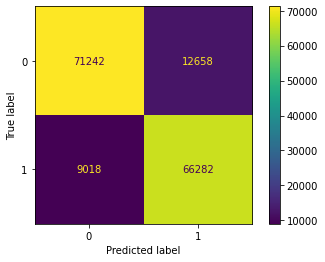

In [29]:
cm_display = ConfusionMatrixDisplay(cm).plot() # 47106

In [30]:
print(classification_report(preds, tests))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     83900
           1       0.84      0.88      0.86     75300

    accuracy                           0.86    159200
   macro avg       0.86      0.86      0.86    159200
weighted avg       0.86      0.86      0.86    159200



In [31]:
cm = confusion_matrix(preds, tests)

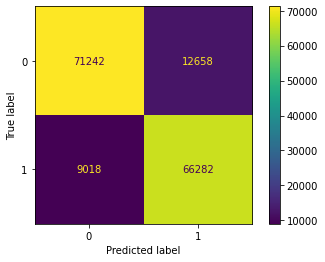

In [32]:
cm_display = ConfusionMatrixDisplay(cm).plot() # 32735 33064 21676